In [2]:
import torch
import torch.nn as nn
import numpy as np
import pickle
import matplotlib.pyplot as plt
import json
import os
import cv2
import torchvision
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch.utils.data.dataloader import default_collate
from torchvision import transforms
import math

from utils.utils import inverse_sigmoid, intersection, get_cell_offsets
from model.yolov3 import YOLOV3
from utils.params import label_map, priors, scales

torch.cuda.is_available()
DATA_DIR = os.path.join('data')

In [3]:
"""
# download coco data (this takes a while)
!rm *zip*
!wget http://images.cocodataset.org/zips/train2017.zip
!unzip train2017.zip -d data
!wget http://images.cocodataset.org/zips/val2017.zip
!unzip val2017.zip -d data
!rm *zip

# download coco labels
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip annotations_trainval2017.zip -d data
"""

'\n# download coco data (this takes a while)\n!rm *zip*\n!wget http://images.cocodataset.org/zips/train2017.zip\n!unzip train2017.zip -d data\n!wget http://images.cocodataset.org/zips/val2017.zip\n!unzip val2017.zip -d data\n!rm *zip\n\n# download coco labels\n!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip\n!unzip annotations_trainval2017.zip -d data\n'

In [4]:
#load coco dataset
!pip install pycocotools
train_ds = torchvision.datasets.coco.CocoDetection('data/train2017', 'data/annotations/instances_train2017.json')
val_ds = torchvision.datasets.coco.CocoDetection('data/val2017', 'data/annotations/instances_val2017.json')

DEPRECATION: Python 2.7 reached the end of its life on January 1st, 2020. Please upgrade your Python as Python 2.7 is no longer maintained. pip 21.0 will drop support for Python 2.7 in January 2021. More details about Python 2 support in pip can be found at https://pip.pypa.io/en/latest/development/release-process/#python-2-support pip 21.0 will remove support for this functionality.
loading annotations into memory...
Done (t=13.97s)
creating index...
index created!
loading annotations into memory...
Done (t=0.78s)
creating index...
index created!


In [5]:
BASE_PATH = os.path.join('data', 'annotations')
TRAIN_DATA_PATH = os.path.join('data', 'train2017')
VAL_DATA_PATH = os.path.join('data', 'val2017')
TRAIN_CAPTIONS_PATH = os.path.join(BASE_PATH, 'captions_train2017.json')
VAL_CAPTIONS_PATH = os.path.join(BASE_PATH, 'captions_val2017.json')
TRAIN_ANNOTATIONS_PATH = os.path.join(BASE_PATH, 'instances_train2017.json')
VAL_ANNOTATIONS_PATH = os.path.join(BASE_PATH, 'instances_train2017.json')

In [6]:
# we use small dataset for now
num_train_images = 100
num_val_images = 100

In [7]:
bbox = list(map(lambda x: (x['bbox'], x['category_id']), train_ds[0][1]))

bowl


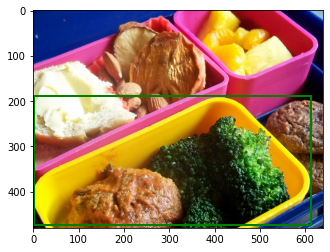

In [8]:
# view a random image with a bounding box for sanity check
i = 0
j = 0
img = train_ds[i][0]
labels = list(map(lambda x: (x['category_id'], *x['bbox']), train_ds[i][1]))
fix, ax = plt.subplots()
cl, x0, y0, w, h = labels[j]
print(label_map[cl])
ax.imshow(img)
rect = plt.Rectangle((x0, y0), w, h, 
                         alpha=1, 
                         fc='none',
                         color ='green',
                         linewidth = 2,
                         )
ax.add_patch(rect)

In [9]:
im = torch.randn((1,3,320,320))
model = YOLOV3()
[det.shape for det in model(im)]

[torch.Size([1, 255, 10, 10]),
 torch.Size([1, 255, 20, 20]),
 torch.Size([1, 255, 40, 40])]

In [10]:
def print_image_tensor(img: torch.Tensor):
    print(img.shape)
    plt.imshow(img.moveaxis(0, 2))

In [11]:
transform1 = transforms.ToTensor()
transform2 = transforms.Normalize(0, 1)

In [18]:
# call_x, cell_y are the distance of the cell from the top right corner. Multiply by 32
def get_gt(label: torch.Tensor, cell_x, cell_y, prior: tuple, scale=32) -> torch.Tensor:
    gt = torch.zeros(5)

    gt[1] = label[1]
    gt[2] = label[2]
    gt[3] = label[3]
    gt[4] = label[4]
    
    prior_w, prior_h = prior
    prior_x = cell_x + (scale // 2)
    prior_y = cell_y + (scale // 2)
    
    
    gt[1] = inverse_sigmoid((gt[1] - cell_x) / 32)
    gt[2] = inverse_sigmoid((gt[2] - cell_y) / 32)
    gt[2] /= 32
    
    
    gt[3] = gt[3] / prior_w
    gt[3] /= 32
    gt[4] = gt[4] / prior_h
    gt[4] /= 32
    
    gt[3] = torch.log(gt[3])
    gt[4] = torch.log(gt[4])

    # inverse sigmoid of the ioU score
    _iou = iou(prior_w, prior_h, label[3], label[4])
    if _iou == 0:
        o = 0
    else:
        o = torch.log(_iou)
    return torch.tensor((*gt, o)) 

def coco2yolo(label: torch.Tensor) -> torch.Tensor:
    yolo = torch.clone(label)
    
    yolo[1] = yolo[1] + (yolo[3] / 2)
    yolo[2] = yolo[2] + (yolo[4] / 2)
    return yolo

def xywh2xyxy(arr: torch.Tensor) -> torch.Tensor:
    x0 = arr[0] - (arr[2] / 2)
    y0 = arr[1] - (arr[3] / 2)
    x1 = x0 + arr[2]
    y1 = y0 + arr[3]
    
    return torch.Tensor((x0, y0, x1, y1))
    
def compare_iou(a, b):
    

    i = abs(a[2] - b[2]) * abs(a[3] - b[3])
    u = abs(a[2] * a[3]) + abs(b[2] * b[3])


    return i / u

def build_groundtruth(arr, bounding_box, scales_index, grid_size):
    bounding_box = coco2yolo(bounding_box)
    # bounding boxes in terms of cells. Should all be 0-10. For x and y, c_x and c_y are their floor
                
    bounding_box[1] /= grid_size
    bounding_box[2] /= grid_size
    bounding_box[3] /= grid_size
    bounding_box[4] /= grid_size

    c_x = torch.floor(bounding_box[1]).type(torch.uint8)
    c_y = torch.floor(bounding_box[2]).type(torch.uint8)
                
    cl = bounding_box[0].type(torch.uint8)
    #y_1[c_x][c_y][prior_num * 85]
                
    # find the prior that has the highest IoU with the bounding box. We only use this prior for loss
    best_iou = -1
    best_prior = priors[scales[0][0]]
                
    i = 0
        
    c_x = int(c_x)
    c_y = int(c_y)
                
    for prior_num in scales[scales_index]:
        prior = priors[prior_num][0] / grid_size, priors[prior_num][1] / grid_size

        prior_w, prior_h = prior

        prior_coords = torch.tensor((bounding_box[1], bounding_box[2], prior_w, prior_h))
        box_coords = bounding_box[1:5]

        iou = compare_iou(prior_coords, box_coords)

        if(iou > best_iou):
            best_iou = iou
            best_prior = prior
            best_prior_index = i

        i += 1
                    
    inv_x = inverse_sigmoid(bounding_box[1] - c_x)
    inv_y = inverse_sigmoid(bounding_box[2] - c_y)
    inv_w = torch.log(bounding_box[3] / best_prior[0])
    inv_h = torch.log(bounding_box[4] / best_prior[1])
    inv_o = iou

    arr[0][best_prior_index * 85][c_x][c_y] = inv_x
    arr[0][best_prior_index * 85 + 1][c_x][c_y] = inv_y
    arr[0][best_prior_index * 85 + 2][c_x][c_y] = inv_w
    arr[0][best_prior_index * 85 + 3][c_x][c_y] = inv_h
    arr[0][best_prior_index * 85 + 4][c_x][c_y] = iou
    """
    if(cl < 80):
        arr[0][best_prior_index * 85 + (5 + int(cl))][c_x][c_y] = 1 
    """
    
    

In [29]:
def train(model, loss_fn, optimizer, epochs, train_dl, valid_dl, num_iterations=None):
    
    batch_size = train_dl.batch_size
    
    # constants for uneven gradient
    l_coord = 5
    l_noobj = 0.5
    
    for epoch in range(epochs):
        
        avg_loss = 0
        acc = 0
        
        val_avg_loss = 0
        val_acc = 0
        batch_num = 0
        
        for batch in tqdm(train_dl):    
            
            x, bboxes = batch
            ### DATA TRANSFORMS AND PROCESSING
            x = x[0]
            bboxes = bboxes[0]
            rescale_factor_w = 320 / x.size[0]
            rescale_factor_h = 320 / x.size[1]
            x = x.resize((320, 320))
            x = transform1(x)
            x = transform2(x)
             
            y_pred_1, y_pred_2, y_pred_3 = model(x.unsqueeze(0))
            y_1 = torch.zeros((1, 255, 10, 10))
            y_2 = torch.zeros((1, 255, 20, 20))
            y_3 = torch.zeros((1, 255, 40, 40))
                                
            for bounding_box in bboxes:
                
                # scale 1
                # only the best prior is used for each bounding box for each detector scale
                
                # some of these get converted to ints when reading bboxes, which makes following op throw an error                
                # xc, yc, w, h
                
                bounding_box = bounding_box.type(torch.float32)
                bounding_box[1] *= rescale_factor_w
                bounding_box[2] *= rescale_factor_h
                bounding_box[3] *= rescale_factor_w
                bounding_box[4] *= rescale_factor_h
                
                build_groundtruth(y_1, torch.clone(bounding_box), 0, 32)
                print("y 1")
                print(y_1[0])
                print("pred")
                print(y_pred_1[0])
                #build_groundtruth(y_2, bounding_box, 0, 16)
                #build_groundtruth(y_3, bounding_box, 0, 8)  
                
            optimizer.zero_grad()
            loss = loss_fn(y_1, y_pred_1)
            #loss = loss_fn(y_1, y_pred_1)
            #loss = loss_fn(y_1, y_pred_1)
            loss.backward()
            optimizer.step()
            
            avg_loss += loss.item()
            
            print(loss.item())
            
            batch_num += 1
            if batch_num > num_iterations:
                break
                                      
        avg_loss /= (len(train_dl) * batch_size)
        #acc /= (len(train_dl) * batch_size)
        
        val_avg_loss /= (len(valid_dl) * batch_size)
        #val_acc /= (len(valid_dl) * batch_size)
        
        
        print(f'epoch: {epoch} loss: {avg_loss} acc: {acc} val_loss: {val_avg_loss} val_acc: {val_acc}')
        


In [31]:
torch.cuda.empty_cache()

model = YOLOV3()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)

loss = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters())

collate_fn = lambda x: ([_x[0] for _x in x], [[torch.tensor((ann['category_id'], *ann['bbox'])) for ann in _x[1]] for _x in x])

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=1, shuffle=True, collate_fn=collate_fn)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size = 1, shuffle=True)

train(model, loss, optimizer, 10, train_dl, val_dl, 100)

ValueError: parameter group didn't specify a value of required optimization parameter lr

### 